# CIFAR10 Colorization

We want to do an image colorization task using PyTorch on CIFAR10 dataset. We want to train a model that colors  a black-and-white image.

## Import Libraries

Import needed libraries

In [4]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torchvision
from sklearn.model_selection import train_test_split
import keras.layers as L
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.datasets import cifar10
import torchvision.datasets as dataset_loader
import torch.nn.functional as F
from PIL import Image
import keras

## Custom Dataset

Define a custom dataset class by extensing `torch.utils.data.Dataset`

**Notice:** your dataset should output two things: black-and-white image and the RGB image

**Hint:** You don't have to reinvent the wheel. Your class should just be a wrapper for CIFAR10 dataset

In [5]:
class CIFARDataset(Dataset):
    def __init__(self):
        (image_train, train_label), (image_test, test_label) = cifar10.load_data()
        image_train, image_val, y_train, y_val = train_test_split(image_train, train_label, test_size=0.15, random_state=42)
        
        train = image_train
        test = image_test
        val = image_val
        
        train = train/255.
        test = test/255.
        val = val/255.
        
        gray_train = np.mean(train, axis=-1)
        gray_train = gray_train.reshape((*gray_train.shape, 1))
        
        gray_test = np.mean(test, axis=-1)
        gray_test = gray_test.reshape((*gray_test.shape, 1))
        
        gray_val = np.mean(val, axis=-1)
        gray_val = gray_val.reshape((*gray_val.shape, 1))

        self.gray_train = gray_train
        self.gray_test = gray_test
        self.gray_val = gray_val

        self.train = train
        self.test = test
        self.val = val
        
    def __len__(self):
        return len(self.rgb_images)

    def __getitem__(self, idx):
        return self.rgb_images, self.gray_images

## Transforms & Dataset & Dataloader

**Notice:** Use your defined custom dataset class for defining the datasets

In [6]:
my_dataset = CIFARDataset()

## Dataset Visualization

Visualize your dataset (black-and-white image along with the RGB image) by sampling from your trainset

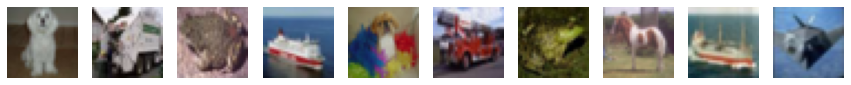

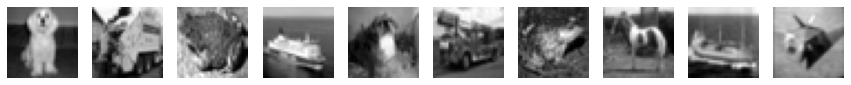

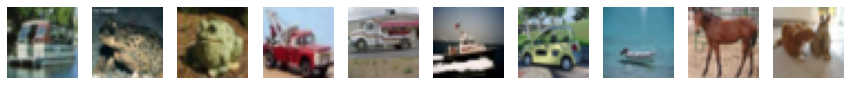

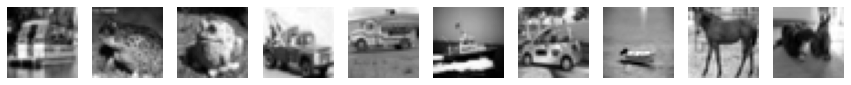

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(15, 8))
upper = my_dataset.train.shape[0]
random_indices = np.random.randint(0, upper, 20)
counter = 0
for row in axes:
    row.imshow(my_dataset.train[random_indices[counter]])
    row.axis('off')
    counter += 1
    
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(15,8))
counter = 0
for row in axes:
    row.imshow(my_dataset.gray_train[random_indices[counter]], cmap=plt.get_cmap("gray"))
    row.axis('off')
    counter += 1
    
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(15,8))
random_indices = np.random.randint(0, upper, 20)
counter = 0
for row in axes:
    row.imshow(my_dataset.train[random_indices[counter]])
    row.axis('off')
    counter += 1
    
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(15,8))
counter = 0
for row in axes:
    row.imshow(my_dataset.gray_train[random_indices[counter]], cmap=plt.get_cmap("gray"))
    row.axis('off')
    counter += 1
        
plt.show()

## Model

Define your model here (Input: black-and-white image, Output: RGB image)

**Hint:** You can implement an autoencoder that does the colorization task for you. UNet could be a viable option 

In [14]:
class UNet:
    
    config = {
        'padding': 'same',
        'size': 64,
        'alpha': 0.2,
        'activation': 'relu',
        'optimizer': 'adam',
        'loss': 'mean_squared_error'
    }
    
    def get_separated_config(self):
        return UNet.config['padding'], UNet.config['size'], UNet.config['alpha'], UNet.config['activation']
    
    
    def __init__(self):
        input_ = L.Input([None, None, 1])
        
        padding, size, alpha, activation = self.get_separated_config()
        
        sizes = [size * (2 ** i) for i in range(5)]
        
        first = L.Conv2D(sizes[0], (3, 3), padding=padding)(input_)
        first = L.BatchNormalization()(first)
        first = L.LeakyReLU(alpha=alpha)(first) 
        first = L.Conv2D(sizes[0], (3, 3), strides=1, padding=padding)(first)
        first = L.BatchNormalization()(first)
        first = L.LeakyReLU(alpha=alpha)(first)
        
        second = L.MaxPool2D((2, 2), strides=2)(first)
        second = L.Conv2D(sizes[1], (3, 3), padding=padding)(second)
        second = L.BatchNormalization()(second)
        second = L.LeakyReLU(alpha=alpha)(second)
        second = L.Conv2D(sizes[1] , (3, 3), padding=padding)(second)
        second = L.BatchNormalization()(second)
        second = L.LeakyReLU(alpha=alpha)(second)
        
        third = L.MaxPool2D((2, 2), strides=2)(second)
        third = L.Conv2D(sizes[2], (3, 3), padding=padding)(third)
        third = L.BatchNormalization()(third)
        third = L.LeakyReLU(alpha=alpha)(third)
        third = L.Conv2D(sizes[2], (3, 3), padding=padding)(third)
        third = L.BatchNormalization()(third)
        third = L.LeakyReLU(alpha=alpha)(third)
        
        fourth = L.MaxPool2D((2, 2), strides=2)(third)
        fourth = L.Conv2D(sizes[3], (3, 3), padding=padding)(fourth)
        fourth = L.BatchNormalization()(fourth)
        fourth = L.LeakyReLU(alpha=alpha)(fourth)
        fourth = L.Conv2D(sizes[3], (3, 3), padding=padding)(fourth)
        fourth = L.BatchNormalization()(fourth)
        fourth = L.LeakyReLU(alpha=alpha)(fourth)
        
        fifth = L.MaxPool2D((2, 2), strides=2)(fourth)
        fifth = L.Conv2D(sizes[4], (3, 3), padding=padding)(fifth)
        fifth = L.BatchNormalization()(fifth)
        fifth = L.LeakyReLU(alpha=alpha)(fifth)
        fifth = L.Conv2D(sizes[4], (3, 3), padding=padding)(fifth)
        fifth = L.BatchNormalization()(fifth)
        fifth = L.LeakyReLU(alpha=alpha)(fifth)
        fifth = L.Conv2DTranspose(sizes[3], (2, 2), strides=2)(fifth)
        fifth = L.Concatenate()([fourth, fifth])
        fifth = L.Conv2D(sizes[3], (3, 3), padding=padding)(fifth)
        fifth = L.BatchNormalization()(fifth)
        fifth = L.Activation(activation)(fifth)
        fifth = L.Conv2D(sizes[3], (3, 3), padding=padding)(fifth)
        fifth = L.BatchNormalization()(fifth)
        fifth = L.Activation(activation)(fifth)
        
        fourth = L.Conv2DTranspose(sizes[2], (2, 2), strides=2)(fifth) 
        fourth = L.Concatenate()([third, fourth])
        fourth = L.Conv2D(sizes[2], (3, 3), padding=padding)(fourth)
        fourth = L.BatchNormalization()(fourth)
        fourth = L.Activation(activation)(fourth)
        fourth = L.Conv2D(sizes[2], (3, 3), padding=padding)(fourth)
        fourth = L.BatchNormalization()(fourth)
        fourth = L.Activation(activation)(fourth)
        
        third = L.Conv2DTranspose(sizes[1], (2, 2), strides=2)(fourth)
        third = L.Concatenate()([second, third])
        third = L.Conv2D(sizes[1], (3, 3), padding=padding)(third)
        third = L.BatchNormalization()(third)
        third = L.Activation(activation)(third)
        third = L.Conv2D(sizes[1], (3, 3), padding=padding)(third)
        third = L.BatchNormalization()(third)
        third = L.Activation(activation)(third)
        
        second = L.Conv2DTranspose(sizes[0], (2, 2), strides=2)(third) 
        second = L.Concatenate()([first, second])
        second = L.Conv2D(sizes[0], (3, 3), padding=padding)(second)
        second = L.BatchNormalization()(second)
        second = L.Activation(activation)(second)
        second = L.Conv2D(sizes[0], (3, 3), padding=padding)(second)
        second = L.BatchNormalization()(second)
        second = L.Activation(activation)(second)

        output_ = L.Conv2D(3, (1, 1), strides=1)(second)
        model = Model(inputs=input_, outputs=output_)
        self.model = model    

unet = UNet().model
unet.compile(UNet.config['optimizer'], loss=UNet.config['loss'])

## Train

Train your model

Tasks:
- [ ] Things that are needed to be printed in each epoch:
  - Number of epoch
  - Train loss
  - Validation loss
- [ ] save train/validation loss (of each epoch) in an array for later usage

In [37]:
num_epochs = 39
history = None
with tf.device("gpu:0"):
    unet.fit(
        my_dataset.gray_train,
        my_dataset.train,
        batch_size=250,
        epochs=num_epochs,
        validation_data=(my_dataset.gray_val, my_dataset.val),
    )
    history = unet.history
unet.save('Unet_Model')

Epoch 1/39
170/170 [==============================] - 1310s 8s/step - loss: 0.0179 - val_loss: 0.0353
Epoch 2/39
170/170 [==============================] - 1310s 8s/step - loss: 0.0065 - val_loss: 0.0159
Epoch 3/39
170/170 [==============================] - 1310s 8s/step - loss: 0.0062 - val_loss: 0.0067
Epoch 4/39
170/170 [==============================] - 1310s 8s/step - loss: 0.0059 - val_loss: 0.0054
Epoch 5/39
170/170 [==============================] - 1310s 8s/step - loss: 0.0055 - val_loss: 0.0051
Epoch 6/39
170/170 [==============================] - 1310s 8s/step - loss: 0.0054 - val_loss: 0.0051
Epoch 7/39
170/170 [==============================] - 1310s 8s/step - loss: 0.0052 - val_loss: 0.0049
Epoch 8/39
170/170 [==============================] - 1310s 8s/step - loss: 0.0052 - val_loss: 0.0052
Epoch 9/39
170/170 [==============================] - 1310s 8s/step - loss: 0.005 - val_loss: 0.0051
Epoch 10/39
170/170 [==============================] - 1310s 8s/step - loss: 0.005 

### Visualize Loss plot

Using the arrays that you have (from task 2 in the above section), visualize the loss plot (train and validation together)

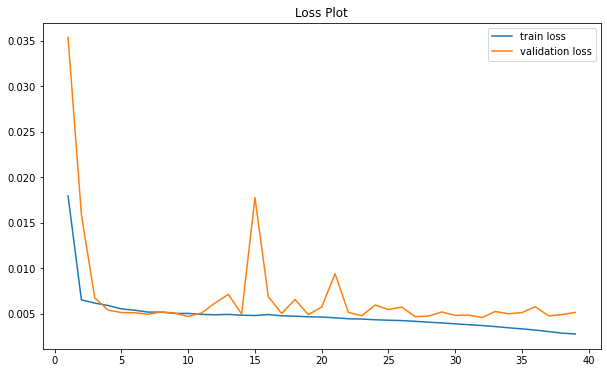

In [42]:
fig, ax = plt.subplots(figsize=(10, 6))
xs = [i+1 for i in range(39)]
ax.plot(xs, history,history.loss)
ax.plot(xs, history,history.val_loss)
ax.legend(['train loss', 'validation loss'])
ax.set_title("Loss Plot")
plt.show()

## Evaluation

1. Sample 36 random samples from testset (your own dataset class)
2. Give each of the 36 samples to your trained model and get the outputs
3. Visualize `input` (black-and-white image), `output` (output of the model with the given black-and-white input image) and `ground truth` (the actual RGB image)



1/1 [==============================] - 0s 167ms/step


1/1 [==============================] - 0s 163ms/step


1/1 [==============================] - 0s 170ms/step


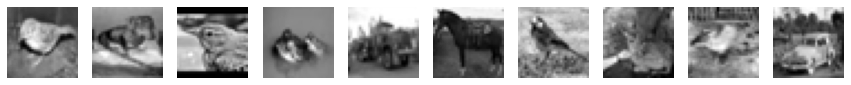

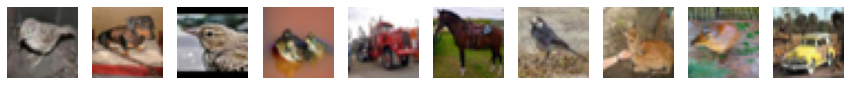

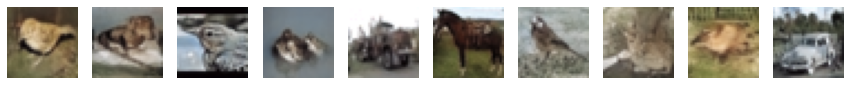

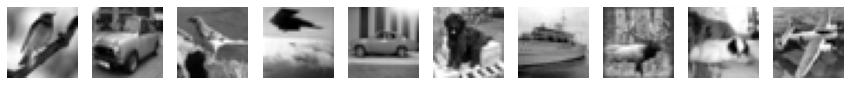

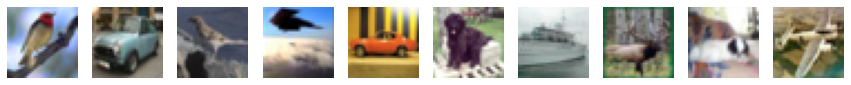

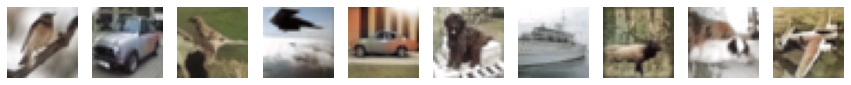

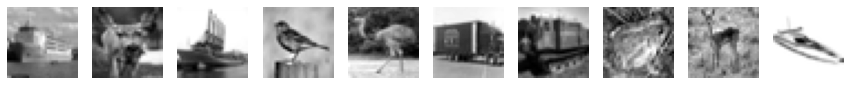

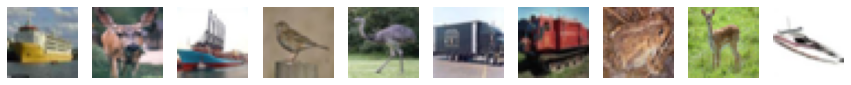

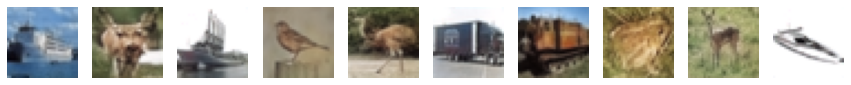

In [35]:
def plot_group(number):
    
    upper = my_dataset.test.shape[0]
    random_indices = np.random.randint(0, upper, number)
    images = my_dataset.test[random_indices]
    grays = my_dataset.gray_test[random_indices]
    predicts = unet.predict(grays)
    
    fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(15, 8))
    counter = 0
    for row in axes:
        row.imshow(grays[counter], cmap=plt.get_cmap("gray"))
        row.axis('off')
        counter += 1

    fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(15,8))
    counter = 0
    for row in axes:
        row.imshow(images[counter])
        row.axis('off')
        counter += 1

    fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(15,8))
    counter = 0
    for row in axes:
        row.imshow(predicts[counter])
        row.axis('off')
        counter += 1

plot_group(10)
plot_group(10)
plot_group(10)
        
plt.show()